# Problem I: Inverse Modeling

## 1. Generating Data

<span style="font-size: 15px;">

In this section, we generate a synthetic dataset inspired by lattice QCD correlators. The correlator is modeled as a sum of 15 exponentially decaying terms:

$$
C(x) = \sum_{i=1}^{15} A_i \cdot x^2 \cdot e^{-c_i \cdot x}
$$

where:
- $x \in [0, 500]$ are the input values (e.g., Euclidean time separations)
- $A_i$ are random amplitudes
- $c_i > 0$ are positive decay constants (related to energy levels)

We will:
1. Generate the correlator data
2. Normalize both inputs and outputs
3. Wrap everything in a PyTorch Dataset and DataLoader

</span>

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import random_split
import torch.optim as optim
torch.manual_seed(42)
np.random.seed(42)

<span style="font-size: 15px;">

We randomly generate 15 amplitudes $A_i \in [0.5, 2.0]$ and decay constants $c_i \in [0.01, 0.1]$.

</span>

In [2]:
# Number of exponential terms
n_terms = 15

# Random amplitudes A_i in [0.5, 2.0]
A = np.random.uniform(0.5, 2.0, size=n_terms)

# Random positive decay constants c_i in [0.01, 0.1]
c = np.random.uniform(0.01, 0.1, size=n_terms)

print("Amplitudes A_i:", np.round(A, 3))
print("Decay constants c_i:", np.round(c, 3))

Amplitudes A_i: [1.062 1.926 1.598 1.398 0.734 0.734 0.587 1.799 1.402 1.562 0.531 1.955
 1.749 0.819 0.773]
Decay constants c_i: [0.027 0.037 0.057 0.049 0.036 0.065 0.023 0.036 0.043 0.051 0.081 0.028
 0.056 0.063 0.014]


In [3]:
def correlator(x, A, c):
    result = np.zeros_like(x, dtype=np.float64)
    for A_i, c_i in zip(A, c):
        result += A_i * x**2 * np.exp(-c_i * x)
    return result

Generate and Normalize the Data

<span style="font-size: 15px;">

We generate 500 data points for $x \in [0, 500]$ and normalize both inputs and outputs to $[0, 1]$ using min-max normalization:

$$
x_{\text{norm}} = \frac{x - x_{\min}}{x_{\max} - x_{\min}}
$$

In [4]:
# Generate input values x from 0 to 500
x_raw = np.linspace(0, 500, 500)

# Compute correlator values
y_raw = correlator(x_raw, A, c)

print(f"x range: [{x_raw.min():.1f}, {x_raw.max():.1f}]")
print(f"C(x) range: [{y_raw.min():.2e}, {y_raw.max():.2e}]")

x range: [0.0, 500.0]
C(x) range: [0.00e+00, 7.06e+03]


In [5]:
def normalize_0_1(data):
    """Normalize data to [0, 1] range"""
    d_min, d_max = data.min(), data.max()
    return (data - d_min) / (d_max - d_min), d_min, d_max

# Normalize inputs and outputs
x_norm, x_min, x_max = normalize_0_1(x_raw)
y_norm, y_min, y_max = normalize_0_1(y_raw)

print(f"Normalized x range: [{x_norm.min():.2f}, {x_norm.max():.2f}]")
print(f"Normalized C(x) range: [{y_norm.min():.2f}, {y_norm.max():.2f}]")

Normalized x range: [0.00, 1.00]
Normalized C(x) range: [0.00, 1.00]


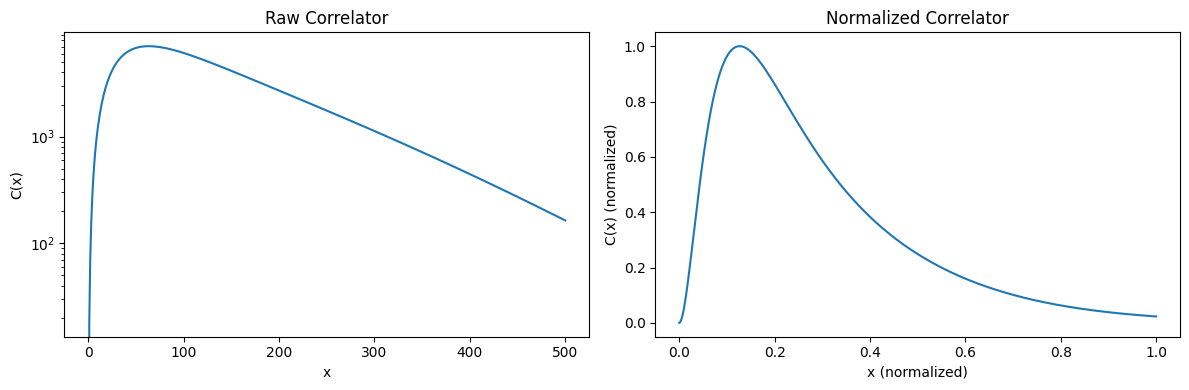

In [6]:
# Visualize the correlator
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(x_raw, y_raw)
axes[0].set_xlabel('x')
axes[0].set_ylabel('C(x)')
axes[0].set_title('Raw Correlator')
axes[0].set_yscale('log')

axes[1].plot(x_norm, y_norm)
axes[1].set_xlabel('x (normalized)')
axes[1].set_ylabel('C(x) (normalized)')
axes[1].set_title('Normalized Correlator')

plt.tight_layout()
plt.show()

**Create the PyTorch Dataset**

<span style="font-size: 15px;">

We wrap our normalized data in a custom `Dataset` class, following the pattern from the reference notebook. The dataset stores $(x_{\text{norm}}, C(x)_{\text{norm}})$ pairs.

</span>

In [7]:
class LatticeQCDCorrelatorDataset(Dataset):
    # Remember, each sample is a (x, C(x)) pair, both normalized to [0, 1]
    def __init__(self, x_normalized, y_normalized):
        self.x = torch.tensor(x_normalized, dtype=torch.float32).unsqueeze(1) # Make the shape (N, 1)
        self.y = torch.tensor(y_normalized, dtype=torch.float32).unsqueeze(1) # Make the shape (N, 1)
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
# Create the dataset:
dataset = LatticeQCDCorrelatorDataset(x_norm, y_norm)
print(f'Dataset size: {len(dataset)} samples')
print(f'Sample shape: x = {dataset[0][0].shape}, y = {dataset[0][1].shape}')

Dataset size: 500 samples
Sample shape: x = torch.Size([1]), y = torch.Size([1])


**Create the DataLoader with Shuffling**

<span style="font-size: 15px;">

**Batch size choice: 32**

We choose `batch_size=32` for the following reasons:

1. **Dataset size**: With 400 training samples, batch size 32 gives us ~12 batches per epoch, providing enough gradient updates for stable learning.

2. **Gradient noise**: Smaller batches (like 32) introduce beneficial stochasticity that helps escape local minima, which is useful for fitting multi-exponential functions.

3. **Memory efficiency**: Small batches are memory-friendly, important if you later want to run on GPU or expand the dataset.

4. **Standard practice**: 32 is a common default that balances training stability with computational efficiency.

**Shuffling**: We enable `shuffle=True` to randomize the order of samples each epoch. This prevents the model from learning spurious patterns based on data ordering (e.g., the sequential nature of $x$ values).

</span>

In [8]:
# Create DataLoader with shufling

batch_size = 32

# Lets split our dataset into train and validation datasets:

train_size = int(0.8 * len(dataset))  # 400 samples
val_size = len(dataset) - train_size   # 100 samples
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f'Batch size: {batch_size}')
print(f'Number of batches: {len(train_loader)}')
print(f'Samples in last batch of training data: {train_size % batch_size}')

Batch size: 32
Number of batches: 13
Samples in last batch of training data: 16


<span style="font-size: 15px;">

Let's verify that the DataLoader works correctly by iterating through a few batches and examining the shuffled data.

</span>

In [9]:
for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
    if batch_idx < 5:
        print(f'Batch {batch_idx}: x shape = {x_batch.shape}, y shape = {y_batch.shape}')
        print(f' x range : [{x_batch.min():.3f}, {x_batch.max():.3f}]')
        print(f' y range : [{y_batch.min():.3f}, {y_batch.max():.3f}]')
    else:
        break

Batch 0: x shape = torch.Size([32, 1]), y shape = torch.Size([32, 1])
 x range : [0.028, 0.990]
 y range : [0.024, 0.988]
Batch 1: x shape = torch.Size([32, 1]), y shape = torch.Size([32, 1])
 x range : [0.008, 1.000]
 y range : [0.023, 0.999]
Batch 2: x shape = torch.Size([32, 1]), y shape = torch.Size([32, 1])
 x range : [0.014, 0.952]
 y range : [0.030, 1.000]
Batch 3: x shape = torch.Size([32, 1]), y shape = torch.Size([32, 1])
 x range : [0.048, 0.962]
 y range : [0.028, 0.962]
Batch 4: x shape = torch.Size([32, 1]), y shape = torch.Size([32, 1])
 x range : [0.010, 0.986]
 y range : [0.025, 0.998]


**Summary**

<span style="font-size: 15px;">

| Component | Value | Description |
|-----------|-------|-------------|
| Dataset size | 500 | Points from $x \in [0, 500]$ |
| Training set | 400 (80%) | Used for parameter optimization |
| Validation set | 100 (20%) | Used for monitoring generalization |
| Exponential terms | 15 | $\sum A_i x^2 e^{-c_i x}$ |
| Normalization | [0, 1] | Min-max scaling for both x and C(x) |
| Batch size | 32 | ~13 batches per epoch (training) |
| Shuffle | True (train) / False (val) | Randomize training order each epoch |

The dataset is now ready to be used for training a neural network to learn the correlator function.

</span>

## NN: Choice I

### 2.1 Architecture Design

**Inverse Problem Formulation:**

Given $C(x) = \sum_{i=1}^{15} A_i \cdot x^2 \cdot e^{-c_i \cdot x}$, we seek $f_\theta: x \mapsto (\{A_i\}, \{c_i\})$ such that:

$$\hat{C}(x; \theta) = \sum_{i=1}^{15} \hat{A}_i(x;\theta) \cdot x^2 \cdot e^{-\hat{c}_i(x;\theta) \cdot x} \approx C(x)$$

**Network Structure:**

$$\mathbb{R}^1 \xrightarrow{\text{Linear}} \mathbb{R}^{64} \xrightarrow{\sigma} \mathbb{R}^{64} \xrightarrow{\text{Linear}} \mathbb{R}^{128} \xrightarrow{\sigma} \mathbb{R}^{128} \xrightarrow{\text{Linear}} \mathbb{R}^{64} \xrightarrow{\sigma} \mathbb{R}^{64} \xrightarrow{\text{Linear}} \mathbb{R}^{30}$$

where output $\in \mathbb{R}^{30} = [A_1, \ldots, A_{15}, c_1, \ldots, c_{15}]$.

### 2.2 Activation Function Selection

**Choice: SiLU (Swish)**

$$\text{SiLU}(x) = x \cdot \sigma(x) = \frac{x}{1 + e^{-x}}$$

**Mathematical Justification:**

1. **Smoothness**: $\text{SiLU} \in C^\infty(\mathbb{R})$ — continuous derivatives of all orders. This is critical because the target function $A \cdot x^2 \cdot e^{-cx}$ is itself smooth.

2. **Non-monotonicity**: Unlike ReLU, SiLU has a slight negative region near $x \approx -1.28$, allowing the network to learn subtle corrections.

3. **Unbounded above**: Range $\approx (-0.278, \infty)$ — can represent the wide dynamic range of correlator values.

4. **No dying neurons**: $\forall x: \frac{d}{dx}\text{SiLU}(x) \neq 0$ (except measure-zero set), avoiding the ReLU "dying neuron" problem.

5. **Self-gating**: The $\sigma(x)$ factor acts as a learned gate, beneficial for regression tasks with exponential decay structure.

**Why not others:**
- **ReLU**: Non-smooth at origin; dying neurons problematic for small dataset (400 samples)
- **Tanh**: Bounded $\in (-1,1)$; vanishing gradients for deep networks
- **Sigmoid**: Output layer only; saturates causing vanishing gradients

### 2.3 Output Constraints and final form

The parameters have physical constraints:
- $A_i \in [0.5, 2.0]$ — amplitudes (positive)
- $c_i \in [0.01, 0.1]$ — decay constants (strictly positive)

**Solution:** Apply **Softplus** to ensure positivity:

$$\text{Softplus}(x) = \ln(1 + e^x) > 0 \quad \forall x \in \mathbb{R}$$

This guarantees $c_i > 0$, which is necessary for the exponential decay $e^{-c_i x}$ to be well-behaved.

In [10]:
class CorrelatorInverseNet(nn.Module):
    #Neural network for inverse modeling of lattice QCD correlators.
    #Maps: x → (A_1, ..., A_15, c_1, ..., c_15)
    #Then computes: Ĉ(x) = Σ A_i · x² · exp(-c_i · x)
    
    def __init__(self, n_terms=15, hidden_dims=[64, 128, 64]):
        super().__init__()
        self.n_terms = n_terms
        # Feature extraction layers
        self.layers = nn.Sequential(
            nn.Linear(1, hidden_dims[0]),
            nn.SiLU(),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.SiLU(),
            nn.Linear(hidden_dims[1], hidden_dims[2]),
            nn.SiLU(),
        )
        
        # Output layer: 2 * n_terms parameters (A_i and c_i)
        self.output_layer = nn.Linear(hidden_dims[-1], 2 * n_terms)
        
        # Softplus for positivity constraint on c_i
        self.softplus = nn.Softplus()
        self.last_Amplitudes = None
        self.last_Decying_Constants = None
    
    def forward(self, x, learning=False):
        """
        Args:
            x: Input tensor of shape (batch_size, 1), normalized ∈ [0, 1]
        
        Returns:
            C_pred: Predicted correlator values, shape (batch_size, 1)
        """
        # Extract features
        features = self.layers(x)
        
        # Predict parameters: [A_1, ..., A_15, c_1, ..., c_15]
        params = self.output_layer(features)
        
        # Split into A and c
        A = params[:, :self.n_terms]              # Shape: (batch, 15)
        c_raw = params[:, self.n_terms:]          # Shape: (batch, 15)
        
        # Ensure c > 0 via Softplus
        c = self.softplus(c_raw)

        # Overwrite (not append)
        if self.training:
            self.last_Amplitudes = A.mean(dim=0).detach()
            self.last_Decying_Constants = c.mean(dim=0).detach()
        
        # Compute correlator: C(x) = Σ A_i · x² · exp(-c_i · x)
        # x has shape (batch, 1), need to broadcast
        x_sq = x ** 2                             # Shape: (batch, 1)
        exp_term = torch.exp(-c * x)              # Shape: (batch, 15)
        
        # Sum over all terms
        C_pred = torch.sum(A * x_sq * exp_term, dim=1, keepdim=True)
        return C_pred
    def get_parameters(self):
        return {'A': self.last_Amplitudes, 'C': self.last_Decying_Constants}

In [11]:
# Instantiate and verify
model = CorrelatorInverseNet(n_terms=15)

# Count parameters
n_params = sum(p.numel() for p in model.parameters())
print(f"Model architecture:\n{model}")
print(f"\nTotal trainable parameters: {n_params:,}")

# Test forward pass
x_test = torch.rand(32, 1)  # Batch of 32 samples
y_pred = model(x_test)
print(f"\nInput shape:  {x_test.shape}")
print(f"Output shape: {y_pred.shape}")

Model architecture:
CorrelatorInverseNet(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): SiLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): SiLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): SiLU()
  )
  (output_layer): Linear(in_features=64, out_features=30, bias=True)
  (softplus): Softplus(beta=1.0, threshold=20.0)
)

Total trainable parameters: 18,654

Input shape:  torch.Size([32, 1])
Output shape: torch.Size([32, 1])


### 2.4 Architecture Summary

| Layer | Input Dim | Output Dim | Activation | Rationale |
|-------|-----------|------------|------------|----------|
| Linear₁ | 1 | 64 | SiLU | Expand input to feature space |
| Linear₂ | 64 | 128 | SiLU | Learn complex feature interactions |
| Linear₃ | 128 | 64 | SiLU | Compress to parameter-relevant features |
| Linear₄ | 64 | 30 | None (+ Softplus on $c_i$) | Output: 15 $A_i$ + 15 $c_i$ |

**Key Design Choices:**

1. **Bottleneck architecture** (64→128→64): Prevents overfitting on 400 samples while maintaining expressivity.

2. **SiLU activation**: Smooth, non-saturating, suitable for regression with exponential targets.

3. **Softplus on $c_i$**: Enforces $c_i > 0$ differentiably, required for physical validity of $e^{-c_i x}$.

4. **Physics-informed forward**: The model embeds the known functional form $A \cdot x^2 \cdot e^{-cx}$ directly, reducing the learning problem from function approximation to parameter estimation.

### 3. Training Loop

#### 3.1 Optimizer Selection: Adam

**Problem characteristics:**
- Small dataset: $N = 400$ training samples
- Non-convex loss landscape (neural network + exponential physics)
- Parameters span different scales: $A_i \in [0.5, 2.0]$, $c_i \in [0.01, 0.1]$

**Why Adam:**

Adam maintains per-parameter adaptive learning rates via:
$$
\theta_t = \theta_{t-1} - \frac{\gamma \hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}
$$
where $\hat{m}_t = \frac{m_t}{1-\beta_1^t}$ (bias-corrected first moment) and $\hat{v}_t = \frac{v_t}{1-\beta_2^t}$ (bias-corrected second moment).

This is critical because:
1. **Scale invariance**: Gradients $\frac{\partial \mathcal{L}}{\partial A_i}$ and $\frac{\partial \mathcal{L}}{\partial c_i}$ differ by orders of magnitude due to $|A_i| \gg |c_i|$. Adam normalizes by $\sqrt{\hat{v}_t}$, equalizing effective step sizes.

2. **Bias correction**: Essential for small datasets. Without correction, early updates are biased toward zero since $m_0 = v_0 = 0$.

**Why not SGD:** Requires manual learning rate tuning per parameter group; impractical for mixed-scale physics parameters.

**Why not AdamW:** Weight decay regularization unnecessary here—the physics-informed structure ($A_i x^2 e^{-c_i x}$) already constrains the hypothesis space.

#### 3.2 Loss Function: MSE

$$
\mathcal{L}(\theta) = \frac{1}{N}\sum_{i=1}^{N} \left( \hat{C}(x_i; \theta) - C(x_i) \right)^2
$$

MSE is the maximum likelihood estimator under Gaussian noise assumption on correlator measurements, which is standard in lattice QCD.

In [12]:
# Hyperparameters
lr = 1e-3          # Default Adam learning rate
beta1 = 0.9        # Exponential decay rate for first moment
beta2 = 0.999      # Exponential decay rate for second moment
eps = 1e-8         # Numerical stability
epochs = 1000

# Initialize
model = CorrelatorInverseNet(n_terms=15)
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(beta1, beta2), eps=eps)
criterion = nn.MSELoss()

#### 3.3 Training Loop Structure

Each epoch performs:
1. **Forward pass**: $\hat{C} = f_\theta(x)$
2. **Loss computation**: $\mathcal{L} = \text{MSE}(\hat{C}, C)$
3. **Backward pass**: $g_t = \nabla_\theta \mathcal{L}$
4. **Adam update**:
   $$
   m_t = \beta_1 m_{t-1} + (1-\beta_1)g_t, \quad v_t = \beta_2 v_{t-1} + (1-\beta_2)g_t^2
   $$
   $$
   \theta_t = \theta_{t-1} - \frac{\gamma}{\sqrt{\hat{v}_t} + \epsilon} \hat{m}_t
   $$

In [13]:
train_losses = []
val_losses = []

for epoch in range(epochs):
    # --- Training ---
    model.train()
    epoch_train_loss = 0.0
    
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()          # Reset gradients: g ← 0
        y_pred = model(x_batch)        # Forward: ŷ = f_θ(x)
        loss = criterion(y_pred, y_batch)  # L = MSE(ŷ, y)
        loss.backward()                # Backward: g = ∇_θ L
        optimizer.step()               # Adam update: θ ← θ - γm̂/(√v̂ + ε)
        epoch_train_loss += loss.item()
    
    train_losses.append(epoch_train_loss / len(train_loader))
    
    # --- Validation ---
    model.eval()
    epoch_val_loss = 0.0
    
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            y_pred = model(x_batch)
            loss = criterion(y_pred, y_batch)
            epoch_val_loss += loss.item()
    
    val_losses.append(epoch_val_loss / len(val_loader))
    
    # Log every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1:4d} | Train Loss: {train_losses[-1]:.6f} | Val Loss: {val_losses[-1]:.6f}")

Epoch  100 | Train Loss: 0.000114 | Val Loss: 0.000275
Epoch  200 | Train Loss: 0.000014 | Val Loss: 0.000019
Epoch  300 | Train Loss: 0.000015 | Val Loss: 0.000004
Epoch  400 | Train Loss: 0.000009 | Val Loss: 0.000006
Epoch  500 | Train Loss: 0.000000 | Val Loss: 0.000000
Epoch  600 | Train Loss: 0.000000 | Val Loss: 0.000000
Epoch  700 | Train Loss: 0.000000 | Val Loss: 0.000000
Epoch  800 | Train Loss: 0.000000 | Val Loss: 0.000000
Epoch  900 | Train Loss: 0.000000 | Val Loss: 0.000000
Epoch 1000 | Train Loss: 0.000000 | Val Loss: 0.000000


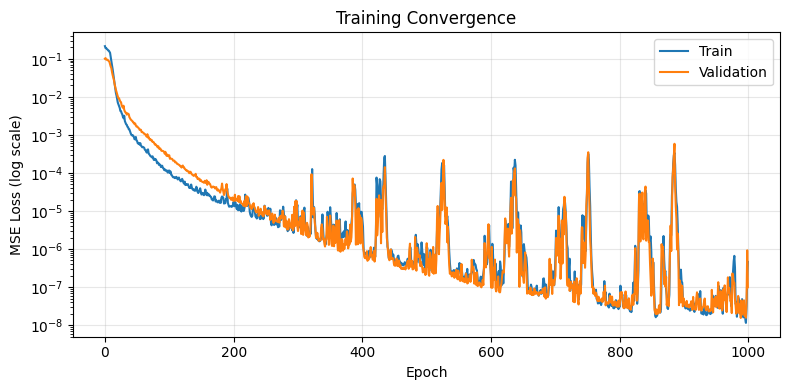

In [14]:
# Convergence visualization
plt.figure(figsize=(8, 4))
plt.semilogy(train_losses, label='Train')
plt.semilogy(val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss (log scale)')
plt.legend()
plt.title('Training Convergence')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [16]:
parameters = model.get_parameters()

In [26]:
C = parameters['C']

In [27]:
A = parameters['A']

In [29]:
print(C)
print(A)

tensor([22.8927, 25.0866, 24.5026,  6.4322, 14.3344, 24.5108, 12.1617,  7.5511,
        11.8359,  8.0723, 24.5413,  7.6050, 19.2098, 25.5018, 17.8166])
tensor([17.2858, 17.9201, 14.6697, 11.0233, 14.8301, 17.5009, 14.5509, 12.9561,
        17.9762, 10.4730, 17.0731, 16.6944, 15.4233, 16.1226, 15.8475])


#### Summary and Conclusion

#### Observation

Despite achieving near-zero training and validation loss, the model **fails to recover the original parameters** $(A_i, c_i)$ that were used to generate the data. The predicted parameters from `model.get_parameters()` differ significantly from the ground truth values.

#### Why This Happens

The fundamental issue is that our network learns a mapping $x \mapsto (A_i(x), c_i(x))$, predicting **different parameters for each input** $x$. However, the original correlator was generated with **fixed, constant** parameters that are the same across all $x$ values.

This creates a **non-identifiable inverse problem**: for any given $x$, there exist infinitely many combinations of $(A_i, c_i)$ that produce the same correlator value $C(x)$. The network exploits this freedom, it finds *some* valid parameterization at each point, but not necessarily *the* original one.

In other words: **low reconstruction loss does not guarantee correct parameter recovery.**

#### Conclusion

This architecture is fundamentally unsuited for the inverse modeling task. To correctly recover the underlying physical parameters, we need a different approach that enforces the parameters to be **global constants** rather than functions of $x$.

## NN: Choice II